In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')

# import the temporal_consistency_check class
from BackGround_modules.Class_5_Temporal_consistency_check import Temporal_consistency_check

In [4]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [5]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

### Import Classified_random_img and Check_sample

In [6]:
# Define the threshold for sum_img of 10 classifications
Threshold_sum_classificatioin = 5

# import the classified imgs,note here we left the last 2 classification of Classified_Landsat_1990_2019 
# beacuse their accuracy are too low
Classified_Landsat_1990_2019  = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_{year}")
                                  .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[:-2]]

Classified_Sentinel_2014_2019 = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Sentinel_Landsat_{year}")
                                  .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[-2:]]

# merge the classified img together
Classified_imgs = Classified_Landsat_1990_2019 + Classified_Sentinel_2014_2019

In [7]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

### Perform temporal consistency check

In [8]:
# get the checked results
Iteration_num = 10
Window_size = [2,3,4,5,6]
modes = ['backward_forward','forward_backward','only_forward','only_backward']

Check_df_list = []

for window in Window_size:
    for mode in modes:
    
        # get the checked classification imgs, here they are stored in a dictionary
        Iter_temporal_check_instaces = Temporal_consistency_check(Classified_imgs,window,Iteration_num)\
                                        .Iterate_the_check(mode = mode)

        # convert the Iter_temporal_check_instaces to a Dataframe
        Check_instances = pd.DataFrame(Iter_temporal_check_instaces).T
        Check_instances.columns = year_range

        # Add the window-size and iteration-num to the df
        Check_instances['Mode'] = [mode] * Iteration_num
        Check_instances['Window'] = [window] * Iteration_num
        Check_instances['Iteration'] = range(1,Iteration_num+1)

        # Reorder the columns
        cols = Check_instances.columns
        Check_instances = Check_instances[list(cols[-3:]) + list(cols[:-3])] 

        # add the checked df into list
        Check_df_list.append(Check_instances)

================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ========

In [9]:
# merge all instace_df together
Check_df = pd.concat(Check_df_list)
Check_df.reset_index(inplace=True,drop=True)

# add the original classification_img to the df
Check_df.loc[-1] = [0,0,0] + Classified_imgs
Check_df.index = Check_df.index + 1  # shifting index
Check_df.sort_index(inplace=True) 

### Assess the accuracy after the temporal check

##### Transform the Check_sample into long format so each row is an observation with spicific window-iteration-year condition

In [10]:
# create sample list for accuracy assesment
Check_sample = [Sample_Landsat] * len(Classified_Landsat_1990_2019) + \
               [Sample_Sentinel] * len(Classified_Sentinel_2014_2019)

Sample_size = [Sample_Landsat.size().getInfo()]  * len(Classified_Landsat_1990_2019) + \
              [Sample_Sentinel.size().getInfo()] * len(Classified_Sentinel_2014_2019)

In [11]:
# attach Check_sample to the Check_instaces_long 
Check_instaces_long = pd.DataFrame(Check_df.set_index(['Mode','Window','Iteration']).stack()).reset_index()
Check_instaces_long.columns = ['Mode','Window','Iteration','year','Image']

In [12]:
# add check_sample and sample_size for later accuracy assessment
Check_instaces_long['Check_sample'] = Check_sample * ( len(modes) * len(Window_size) * (Iteration_num) + 1)
Check_instaces_long['Sample_size']  = Sample_size *  ( len(modes) * len(Window_size) * (Iteration_num) + 1)

# extract checked_img pixel value to sample
Check_instaces_long['Sample_extract_img_value'] = Check_instaces_long.apply(lambda x: ee.Image(x['Image'])\
                                                                                         .sampleRegions(collection = x['Check_sample'], 
                                                                                                        properties = ['Built'], 
                                                                                                        scale      = 30,
                                                                                                        tileScale  = 4),1)

Check_instaces_long['Correct_num'] = Check_instaces_long.apply(lambda x: ee.FeatureCollection(x['Sample_extract_img_value'])\
                                                                        .filter(ee.Filter.equals('Built',None,'classification'))\
                                                                        .size(),1)


In [13]:
# create a pseudo fe_col that contains an random point with the data we need as attributes
Feature_correct_num = [ee.Feature(ee.Geometry.Point([0,0]),{'Mode': fe['Mode'],
                                                            'Window':fe['Window'],
                                                            'Iteration':fe['Iteration'],
                                                            'Correct_num':fe['Correct_num'],})
                      for _,fe in Check_instaces_long.iterrows()]


# export the fe_col, so we dont need to waite for the computation in Python, 
# which also avoid 'GEE capcacity exceed' problem
asset_path = 'users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked'

# task = ee.batch.Export.table.toAsset(   collection  = ee.FeatureCollection(Feature_correct_num),
#                                         description = 'Temporal_check_accuracy',
#                                         assetId     = f'{asset_path}/Temporal_check_accuracy') 

# task.start()

##### Calculate the accuracy in Python, which will take a loooog time

In [14]:
# chunk_size = 10
# correct_num_list = []

# unsuccess_idx = []

# # chop the featurecollection into several sub-list, so we can apply map function
# # to decrease the computation time
# for i in range(0,len(Check_instaces_long),chunk_size):
    
#     # subset from the Check_instaces_long df
#     sub_df = Check_instaces_long.iloc[i:i+chunk_size]
    
#     # using try-except to avoid interupt during the process
#     try:
    
#         # get attributes
#         md = sub_df['Mode'].values
#         wd = sub_df['Window'].values
#         it = sub_df['Iteration'].values
#         yr = sub_df['year'].values
#         sz = sub_df['Sample_size'].values

#         # covert the fe_col into a ee.List
#         sample_ext_img = list(sub_df['Sample_extract_img_value'].values)
#         sample_ext_img_list = ee.List(sample_ext_img)

#         # get the value
#         correct_num =  sample_ext_img_list.map(lambda x: ee.FeatureCollection(x)\
#                                                             .filter(ee.Filter.equals('Built',None,'classification')).size())\
#                                                             .getInfo()

#         # storge the attribute into a df
#         tmp_df = pd.DataFrame([md,wd,it,yr,sz,correct_num],index=['Mode','Window','Iteration',
#                                                                    'year','Size','Correct_num']).T

#         # add the correct_num to list
#         correct_num_list.append(tmp_df)

#         # print out the process
#         print(f'{i+chunk_size}/{len(Check_instaces_long)} finished!')
        
#     except:
        
#         # record the unsuccessful index 
#         unsuccess_idx.append(range(i,i+chunk_size))
        
#         # print out the process
#         print(f'{i}_{i+chunk_size} was not successful!')

##### Compute the accuracy after temporal-check

In [15]:
# # Calculate the checked accuracy
# Checked_acc = pd.concat(correct_num_list)
# Checked_acc['Accuracy'] = Checked_acc['Correct_num']/Checked_acc['Size']*100

# # Save the accuracy to disk
# Checked_acc.to_csv('./Result/Temporal_check_acc.csv',index=False)

# load the acc_df
Checked_acc = pd.read_csv('./Result/Temporal_check_acc.csv')

# concert these columns into category, so we can make figures
Checked_acc['Iteration'] = Checked_acc['Iteration'].astype('category')
Checked_acc['year'] = Checked_acc['year'].astype('category')

In [16]:
Checked_acc

,Mode,Window,Iteration,year,Size,Correct_num,Accuracy
0,0,0,0,1990_1992,1980,1962,99.090909
1,0,0,0,1993_1995,1980,1963,99.141414
2,0,0,0,1996_1998,1980,1964,99.191919
3,0,0,0,1999_2001,1980,1958,98.888889
4,0,0,0,2002_2004,1980,1956,98.787879
...,...,...,...,...,...,...,...
2005,only_backward,6,10,2005_2007,1980,1968,99.393939
2006,only_backward,6,10,2008_2010,1980,1971,99.545455
2007,only_backward,6,10,2011_2013,1980,1962,99.090909
2008,only_backward,6,10,2014_2016,2017,1989,98.611800


##### Observe that the forward_backward mode are the best mode

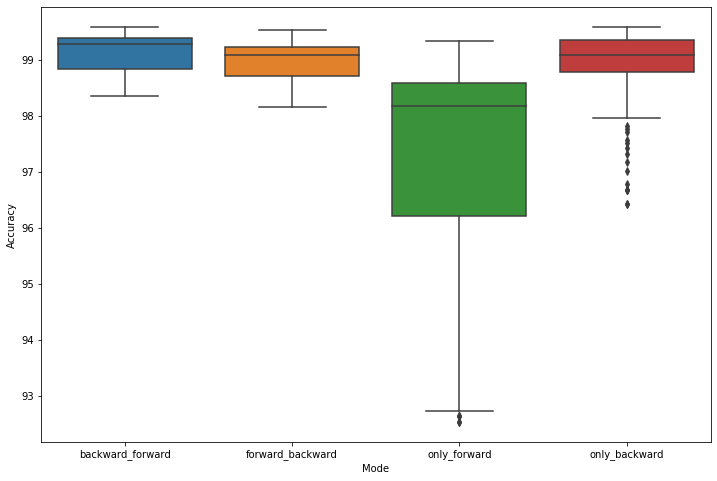

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(data = Checked_acc[Checked_acc['Mode']!='0'],x='Mode',y='Accuracy')

##### Observe that  9 iterations  achieved a stable accuracy. here we neglect the seemingly high accuracy at lower iterations because we care more about stable performance, which is the key of temporal correction

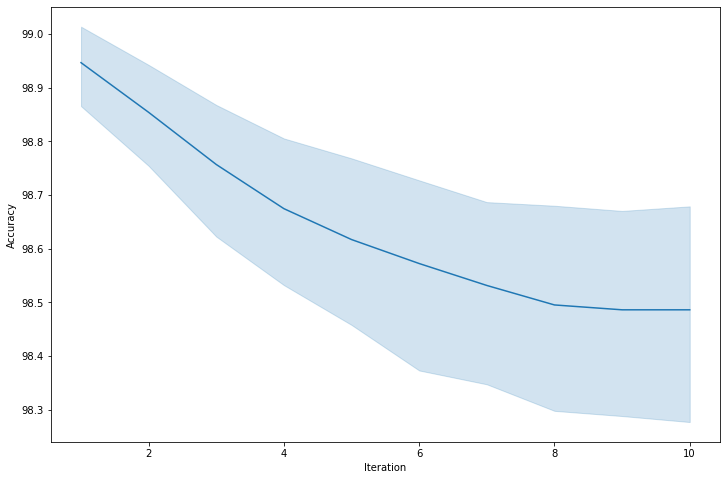

In [18]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc[Checked_acc['Mode']!='0'],x='Iteration',y='Accuracy')

##### Observe that window-size of 3 is the optimun size, because the bigger the window size, the more imgs wouldn't be temporal corrected. So we choose 3 as window size even though 5 look like the best one

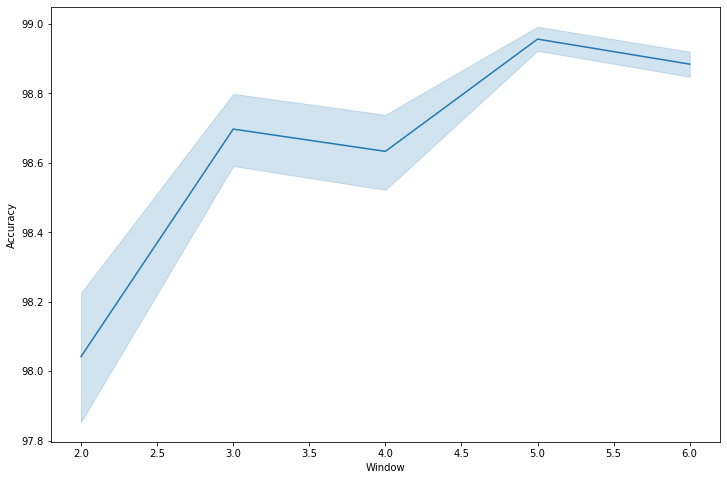

In [19]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc[Checked_acc['Mode']!='0'],x='Window',y='Accuracy')

##### Observe that the temporal correction significatly increses the classification accuracy

In [24]:
# access the acc_df
Sentinel_Acc = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy_landsat_sentinel.csv')
Landsat_Acc  = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy.csv')

In [33]:
landsat_col = ['Landsat_1990_1992', 'Landsat_1993_1995', 'Landsat_1996_1998','Landsat_1999_2001',
               'Landsat_2002_2004', 'Landsat_2005_2007','Landsat_2008_2010', 'Landsat_2011_2013']

In [36]:
Original_landsat = Landsat_Acc[Landsat_Acc['year'].isin(landsat_col)]
Original_acc = pd.concat([Original_landsat,Sentinel_Acc])

In [39]:
Original_acc['Year'] = Original_acc['year'].apply(lambda x: x[-9:])
Original_acc

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built,Year
0,Landsat_1990_1992,0,94.10,93.90,94.30,94.51,93.67,1990_1992
1,Landsat_1990_1992,1,94.20,93.75,94.68,95.06,93.28,1990_1992
2,Landsat_1990_1992,2,95.18,94.37,96.03,96.14,94.22,1990_1992
3,Landsat_1990_1992,3,94.53,93.90,95.18,95.28,93.78,1990_1992
4,Landsat_1990_1992,4,94.89,94.31,95.50,95.70,94.06,1990_1992
...,...,...,...,...,...,...,...,...
15,Sentinel_2017_2019,5,94.83,95.91,93.72,93.99,95.72,2017_2019
16,Sentinel_2017_2019,6,94.03,93.19,94.88,94.83,93.25,2017_2019
17,Sentinel_2017_2019,7,93.61,92.87,94.34,94.13,93.12,2017_2019
18,Sentinel_2017_2019,8,94.26,94.67,93.85,93.96,94.57,2017_2019


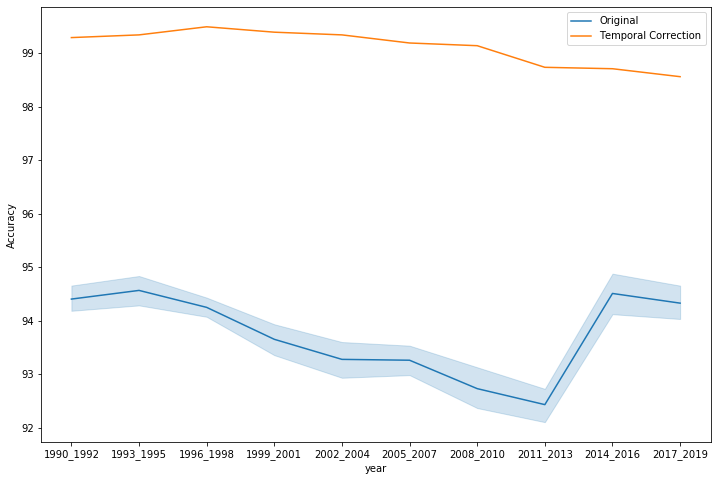

In [46]:
plt.figure(figsize=(12,8))


sns.lineplot(data = Original_acc,x = 'Year',y='Overall_ACC',label = 'Original')
sns.lineplot(data = Checked_acc[((Checked_acc['Window']==3)&
                                 (Checked_acc['Iteration']==9)&
                                 (Checked_acc['Mode']=='forward_backward'))],
             x='year',
             y='Accuracy',
            label = 'Temporal Correction')

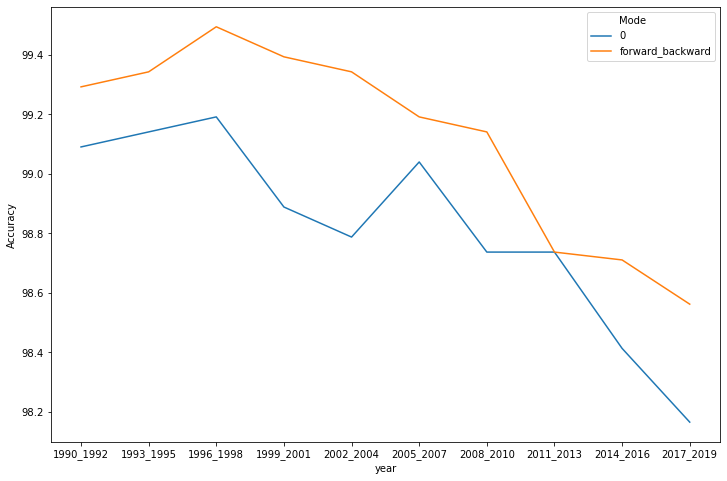

In [40]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc[(Checked_acc['Mode']=='0')|((Checked_acc['Window']==3)&
                                                            (Checked_acc['Iteration']==9)&
                                                            (Checked_acc['Mode']=='forward_backward'))],
             x='year',
             y='Accuracy',
             hue = 'Mode')

##### Export the imgs that being temporal-checked with a window size of 3

In [17]:
# import the export region
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [18]:
# here we find that temporcal checked img with 
# "Mode=forward_backward", "Iteration=5", "Window=3"
# are the best quality imgs

Target_temporal_checked = Check_instaces_long[(Check_instaces_long['Mode']      == 'forward_backward')&\
                                              (Check_instaces_long['Iteration'] == 9)&\
                                              (Check_instaces_long['Window']    == 3)]

In [19]:
# export all temporal checked imgs
for idx,row in Target_temporal_checked.iterrows():
    
    Mode      = row[0]
    Window    = row[1]
    Iteration = row[2]
    year      = row[3]
    img       = row[4]
    
    # determine the img name
    export_name = f'{Mode}_Window_{Window}_It_{Iteration}_{year}'
    
#     task = ee.batch.Export.image.toCloudStorage(image = img,
#                                                 description=export_name,
#                                                 bucket='north_china_plain',
#                                                 fileNamePrefix=export_name,
#                                                 region=North_China_Plain.geometry().bounds(),
#                                                 scale=30,
#                                                 maxPixels=int(1e13),
#                                                 skipEmptyTiles=True) 
    
#     task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting forward_backward_Window_3_It_9_1990_1992 successful!
Exporting forward_backward_Window_3_It_9_1993_1995 successful!
Exporting forward_backward_Window_3_It_9_1996_1998 successful!
Exporting forward_backward_Window_3_It_9_1999_2001 successful!
Exporting forward_backward_Window_3_It_9_2002_2004 successful!
Exporting forward_backward_Window_3_It_9_2005_2007 successful!
Exporting forward_backward_Window_3_It_9_2008_2010 successful!
Exporting forward_backward_Window_3_It_9_2011_2013 successful!
Exporting forward_backward_Window_3_It_9_2014_2016 successful!
Exporting forward_backward_Window_3_It_9_2017_2019 successful!


##### Add the checked img to the map

In [20]:
Map = geemap.Map()
Map.setCenter(115.4508, 35.2492,10)

# define filter parameters
mode = 'forward_backward' # 'backward_forward' |'forward_backward'|'only_forward'|'only_backward'
window_len = 3
year_idx = '1999_2001'


# get the temporal checked imgs
Temporal_checkd = Check_instaces_long[(Check_instaces_long['Mode']   == mode)&
                                      (Check_instaces_long['Window'] == window_len)&
                                      (Check_instaces_long['year']   == year_idx)]

# get the checked img with different iteration
img_year_window_filtered = [Temporal_checkd[Temporal_checkd['Iteration'] == i]['Image'].values[0] 
                            for i in range(1,Iteration_num + 1)]


# get the original img
Original_img = Check_instaces_long[(Check_instaces_long['Mode']   == 0)&
                                   (Check_instaces_long['Window'] == 0)&
                                   (Check_instaces_long['year']   == year_idx)]['Image'].values[0]

# add the img to map
Map.add_basemap('HYBRID')
Map.addLayer(Original_img,                {'min':0,'max':1},'original')

Map.addLayer(img_year_window_filtered[0], {'min':0,'max':1},'Iter_1')
Map.addLayer(img_year_window_filtered[2], {'min':0,'max':1},'Iter_3')
Map.addLayer(img_year_window_filtered[4], {'min':0,'max':1},'Iter_5')
Map.addLayer(img_year_window_filtered[6], {'min':0,'max':1},'Iter_7')
Map.addLayer(img_year_window_filtered[8], {'min':0,'max':1},'Iter_9')
Map.addLayer(img_year_window_filtered[9], {'min':0,'max':1},'Iter_10')

Map

Map(center=[35.2492, 115.4508], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…